In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Import Libraries
We will use [huggingface transformers](https://github.com/huggingface/transformers) library to train our bert model for sequence classification task. Various other transformer models such as RoBERTa, DistilBERT, XLNET,.. can be used but these models have a lot of computational requirements just for fine-tuning. 

In [2]:
!pip install -q transformers

     |████████████████████████████████| 573kB 299kB/s 
     |████████████████████████████████| 3.7MB 1.1MB/s 
     |████████████████████████████████| 1.0MB 42.4MB/s 
     |████████████████████████████████| 890kB 44.0MB/s 


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import os
os.chdir('/gdrive/My Drive/reddit_india/')

In [0]:
import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [5]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.60
transformers version : 2.8.0


# Import data
We wil only test the BERT model for combined features as lot of training time and cost is required.

In [6]:
df=pd.read_csv('./data.csv')
df.shape

(1800, 12)

In [7]:
df.head(3)

,title,score,id,body,author,flair,url,comms_num,created,comment,authors,combined_features
0,"Lost my Job, Sick Mother and Paralysed Dad, In...",1042,g014wc,Hi....It's really tough time for everyone. I r...,sanand_satwik,AskIndia,https://www.reddit.com/r/india/comments/g014wc...,132,1.586742e+09,I'm a freelancer. Don't listen to the idiots ...,hashedram diabapp xataari Aashayrao sarcrasti...,"Lost my Job, Sick Mother and Paralysed Dad, In..."
1,Why does the government come with a begging bo...,647,fxofyu,"We have floods, terrorist attacks, famines due...",TWO-WHEELER-MAFIA,AskIndia,https://www.reddit.com/r/india/comments/fxofyu...,205,1.586448e+09,I don't understand why they don't use money f...,Kinky-Monk ak32009 fools_eye None DwncstSheep...,Why does the government come with a begging bo...
2,Mother's condition is going worse due to hepat...,756,g0zlly,"Hi folks, I really appreciate the warm respons...",sanand_satwik,AskIndia,https://www.reddit.com/r/india/comments/g0zlly...,92,1.586871e+09,If anyone knows who is influential on Twitter...,AlternativeDrop6 TheRobotsHaveCome lanky32 pl...,Mother's condition is going worse due to hepat...


In [8]:
np.unique(df['flair'],return_counts=True)

(array(['AskIndia', 'Business/Finance', 'Food', 'Non-Political', 'Photography', 'Policy/Economy', 'Politics',
        'Science/Technology', 'Sports'], dtype=object),
 array([200, 200, 200, 200, 200, 200, 200, 200, 200]))

In [9]:
df=df[['flair','title']]
df["flair"].apply(lambda x:str(x))
df.dropna()
df.head()

,flair,title
0,AskIndia,"Lost my Job, Sick Mother and Paralysed Dad, In..."
1,AskIndia,Why does the government come with a begging bo...
2,AskIndia,Mother's condition is going worse due to hepat...
3,AskIndia,Men who are 30+ and have decided not to get ma...
4,AskIndia,"r/India: If money is no bar, would you prefer ..."


In [0]:
all_flairs=list(np.unique(df['flair']))
df['flair']=df['flair'].apply(lambda x :all_flairs.index(x))
all_flairs=list(np.unique(df['flair']))

# Transformer Models

In [0]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [0]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base'


model_type = 'bert'
pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [0]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [46]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['bert-base-uncased', 'bert-large-uncased', 'bert-base-cased', 'bert-large-cased', 'bert-base-multilingual-uncased', 'bert-base-multilingual-cased', 'bert-base-chinese', 'bert-base-german-cased', 'bert-large-uncased-whole-word-masking', 'bert-large-cased-whole-word-masking', 'bert-large-uncased-whole-word-masking-finetuned-squad', 'bert-large-cased-whole-word-masking-finetuned-squad', 'bert-base-cased-finetuned-mrpc', 'bert-base-german-dbmdz-cased', 'bert-base-german-dbmdz-uncased', 'bert-base-japanese', 'bert-base-japanese-whole-word-masking', 'bert-base-japanese-char', 'bert-base-japanese-char-whole-word-masking', 'bert-base-finnish-cased-v1', 'bert-base-finnish-uncased-v1', 'bert-base-dutch-cased'])

In [0]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [0]:
seed_all(seed)

In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [0]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})


In [0]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [0]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [54]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']
[16183, 4904, 1039, 9765, 25175, 1010, 7592, 2009, 1055, 2033]


['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']

Split into train and validation set

In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df)

In [24]:
np.unique(train['flair'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([158, 151, 146, 137, 154, 158, 143, 150, 153]))

 Create Databunch

In [55]:
databunch = (TextList.from_df(train, cols='title', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'flair')
             .add_test(val)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [56]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


text,target
"[CLS] hey , guys ! when i posted the tea & id ##li video , u / wr ##omi ##t suggested that i should try "" tan ##door ##i leg "" with tea . i couldn ' t find a leg piece , but i found what they call "" ti ##kka . "" at first , i wasn ' t too sure about it , but after i tried",2
"[CLS] it ' s possible to follow social di ##stan ##cing and eat healthy meals w / o shopping haul ##s . below is my prep for 5 people for next 21 days . ve ##gg ##ies pre - treated and frozen in pre measured quantities , other food like chan ##a , ch ##hole , etc . + fish ( frozen ) . stay home . tell your elders",2
"[CLS] and ##rom ##eda galaxy ( mess ##ier 31 / m3 ##1 ) / winter night sky through the ceiling of kira ##du temple , bar ##mer rajasthan and ##rom ##eda galaxy / m3 ##1 is a spiral galaxy approximately 2 . 5 million light - years from earth . kira ##du temple - a group of temples from the 11th & 12th century | 1600 x 158 ##2 [SEP]",4
"[CLS] distress ##ing qu ##aran ##tine ##d days : i picked up a hobby of color ##izing old black and white photos . this is a photo of the 12th nawab beg ##um of b ##hop ##al , beg ##um sa ##ji ##da sultan , . © photograph by k . l . syed & co . , c . 1938 - 1940 . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]",3
"[CLS] during lock ##down , uttar ##akh ##and cm ( on ami ##t shah ' s orders ) arranged 28 buses to transport 1800 gujarati devotees stranded in hari ##d ##war back to ahmedabad . uttar ##akh ##and workers in ahmedabad were then du ##ped of rs . 1800 ##0 and stranded midway when they tried to use these buses to return home . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]",6


In [57]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([16, 88])
tensor([[  101,  4931,  1010,  ..., 11519,  1012,   102],
        [  101,  1031,  1051,  ...,     0,     0,     0],
        [  101,  9932,  5714,  ...,     0,     0,     0],
        ...,
        [  101,  2634,  2012,  ...,     0,     0,     0],
        [  101,  2024,  2111,  ...,     0,     0,     0],
        [  101,  1045,  2444,  ...,     0,     0,     0]])


In [0]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [59]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = len(all_flairs)
config.use_bfloat16 = use_fp16
print(config)

BertConfig {
  "_num_labels": 9,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  

In [0]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [0]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()


In [0]:
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [66]:
# learner.split(list_layers)
# num_groups = len(learner.layer_groups)
# print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): Linear(in_features=768, out_features=768, bias=True)
  (6): Linear(in_features=768, out_features=768, bias=True)
  (7): Linear(in_features=768, out_features=768, bias=True)
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=768, out_features=768, bias=True)
  (10): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=768, out_features=3072, bias=True)
  (13): Linear(in_features=3072, out_features=768, bias=True)
  (14): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=768, out_features=768, bias=True)
  (17): Linear(in_features=768, out_features=768, bias=True)
  (18): Linear(in_features=768, out_features=768, bias=True)
  (19): D

In [0]:
learner.save('untrain')
seed_all(seed)
learner.load('untrain');

In [63]:
learner.freeze_to(-1)
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-05
Min loss divided by 10: 1.32E-05


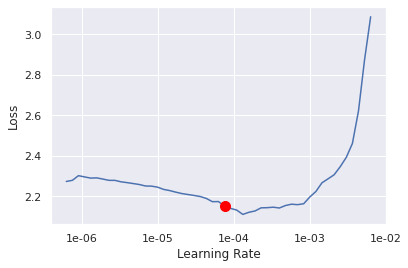

In [64]:
learner.recorder.plot(skip_end=10,suggestion=True)

In [62]:
learner.predict('if you need help with some groceries and food')

(Category 2,
 tensor(2),
 tensor([0.0792, 0.1484, 0.1842, 0.0787, 0.0988, 0.1168, 0.0965, 0.0465, 0.1508]))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.569046,1.263031,0.592593,0.407407,00:07


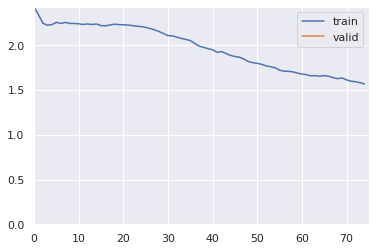

In [65]:
learner.fit_one_cycle(1,max_lr=2e-05,moms=(0.8,0.7))

In [39]:
{0:'AskIndia', 1:'Business/Finance', 2:'Food', 3:'Non-Political', 4:'Photography', 5:'Policy/Economy', 6:'Politics',
        7:'Science/Technology', 8:'Sports'}

array([0, 1, 2, 3, 4, 5, 6, 7, 8])